# WORKSHOP 2
# DEVELOPED BY : NITHISHKUMAR S
# REG NO : 212223240109

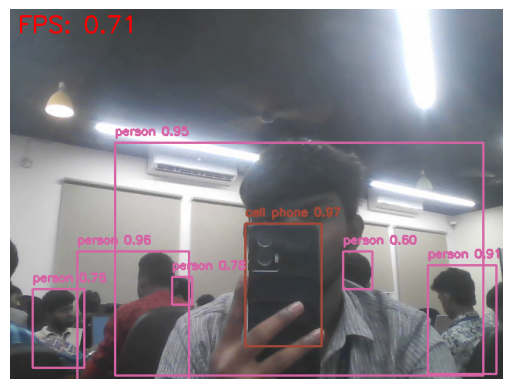

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import time

# Load YOLOv4 network
net = cv2.dnn.readNet("yolov4.weights", "yolov4.cfg")

# Load COCO class labels
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Output layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

# Colors for each class
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# Set up webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open webcam")
    exit()

# FPS calculation
prev_time = 0

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        # Resize frame for faster processing
        frame = cv2.resize(frame, (640, 480))
        height, width, channels = frame.shape

        # Prepare image for YOLOv4
        blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
        net.setInput(blob)
        outputs = net.forward(output_layers)

        boxes = []
        confidences = []
        class_ids = []

        for output in outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    x = max(0, int(center_x - w / 2))
                    y = max(0, int(center_y - h / 2))
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

        if len(indexes) > 0:
            for i in indexes.flatten():
                x, y, w, h = boxes[i]
                label = str(classes[class_ids[i]])
                confidence = confidences[i]
                color = colors[class_ids[i]]
                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
                cv2.putText(frame, f"{label} {confidence:.2f}", (x, y - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Calculate and display FPS
        curr_time = time.time()
        fps = 1 / (curr_time - prev_time)
        prev_time = curr_time
        cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Convert BGR to RGB for matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display frame inline
        clear_output(wait=True)
        plt.imshow(frame_rgb)
        plt.axis('off')
        display(plt.gcf())

except KeyboardInterrupt:
    print("Stopped by user")

finally:
    cap.release()
    plt.close()